In [26]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

import seaborn as sns
sns.set()

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
input_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_query.csv'
DATASET_SIZE = 3
LOOKBACK = 20

In [78]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [79]:
def normalize(X, mu, sigma):
  return (X - mu)/sigma 

def reverse_normalize(X, mu, sigma):
  return X*sigma + mu 

def preprocess_timeseries(_timeseries, lookback=1, normalized=False, mu = None, sigma = None):
  if not normalized:
    if mu is None:
      mu = _timeseries.mean()
    if sigma is None:
      sigma = _timeseries.std()

    timeseries = normalize(_timeseries, mu, sigma)
  else:
    timeseries = _timeseries
  # divide the time series in input instances of X: #lookback steps y: #lookback+1-th value of the time series 
  # so we acquire #df * (complexity(df)-lookback)
  X = None
  y = None
  for i in range(lookback, len(timeseries)):
    X_i = np.asarray(timeseries[i-lookback:i]).reshape((1, len(timeseries[i-lookback:i]), 1))
    X = np.concatenate((X, X_i)) if X is not None else X_i
    y_i = np.asarray(timeseries[i]).reshape((-1, 1))
    y = np.concatenate((y, y_i)) if y is not None else y_i
    

  return X, y, mu, sigma

In [80]:
class TimeSeriesForecastModel():
  def __init__(self, input_dim, lstm_units, dropout=None, _optimizer='adam', _loss='mse'):
    self.history = None
    self.D_train = None
    self.D_test = None
    self.lstm_units = lstm_units
    self.dropout = dropout
    self.optimizer = _optimizer
    self.loss = _loss
    self.input_dim = input_dim

    # create the model architecture
    self.model = models.Sequential()
    for i, u in enumerate(self.lstm_units):
      if i == 0: 
        self.model.add(layers.LSTM(units=u, return_sequences=True, input_shape=self.input_dim))
      elif i == len(self.lstm_units) - 1:
        self.model.add(layers.LSTM(units=u))
      else: 
        self.model.add(layers.LSTM(units=u, return_sequences=True))
      if self.dropout is not None:
        self.model.add(layers.Dropout(self.dropout))

    # final output layer
    self.model.add(layers.Dense(input_dim[-1]))
    
    self.model.compile(optimizer=self.optimizer, loss=self.loss)

  def fit(self, X, y, epochs=100, batch_size=128):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    self.D_train = X_train, y_train
    self.D_test = X_test, y_test
    self.history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    return self.history

  def predict(self, X):
    return self.model.predict(X)

  def evaluate(self, X, y_true):
    """The evaluate function will print a graph of all """
    return self.model.evaluate(X, y_true, batch_size=64)

In [81]:
model = TimeSeriesForecastModel((LOOKBACK, 1), [50, 50, 100], dropout=0.4)

In [96]:
class TimeSeriesForecast():
  def __init__(self, model, dataset, timeseries_labels=None):
    self.dataset = dataset
    self.model = model
    self.history = []
    self.trained = False
    self.eval_data = []
    self.labels = timeseries_labels
    self.mu = []
    self.sigma = []

  def solve(self, lookback=4, epochs=10, batch_size=128):
    self.trained = True
    for timeseries in self.dataset:
      # preprocess timeseries
      X_normalized, y_normalized, mu, sigma = preprocess_timeseries(timeseries, lookback) 
      self.mu.append(mu)
      self.sigma.append(sigma)

      # train the model
      X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.33, shuffle=True)
      h = self.model.fit(X_train, y_train, epochs, batch_size)
      self.history += [h]

      # add the eval data in the respective array
      self.eval_data.append((X_test, y_test))

  def plot_graphs(self, timeseries_idx=None):
    if not self.trained:
      raise Exception("Problem not solved")
    if timeseries_idx is None:
      timeseries_idx = range(len(self.labels))

    figure(figsize=(20, 10))
    lgnd = []
    for i in timeseries_idx:
     lgnd += [f'{self.labels[i]}-True', f'{self.labels[i]}-Pred']
     X, y = self.eval_data[i] 
     plt.plot(range(len(y.reshape(-1))), reverse_normalize(y, self.mu[i], self.sigma[i]).reshape(-1), 'o-')
     y_pred = self.model.predict(X)
     plt.plot(range(len(y_pred.reshape(-1))), reverse_normalize(y_pred, self.mu[i], self.sigma[i]).reshape(-1), 'o-')

    plt.legend(lgnd)


In [97]:
problem = TimeSeriesForecast(model, timeseries_df.to_numpy(), TIME_SERIES_ID)

In [98]:
problem.solve(lookback=LOOKBACK, epochs=20)

Epoch 1/20
3/3 [==============================] - 0s 86ms/step - loss: 0.0385 - val_loss: 0.0152
Epoch 2/20
3/3 [==============================] - 0s 52ms/step - loss: 0.0369 - val_loss: 0.0150
Epoch 3/20
3/3 [==============================] - 0s 45ms/step - loss: 0.0310 - val_loss: 0.0150
Epoch 4/20
3/3 [==============================] - 0s 57ms/step - loss: 0.0364 - val_loss: 0.0153
Epoch 5/20
3/3 [==============================] - 0s 58ms/step - loss: 0.0337 - val_loss: 0.0151
Epoch 6/20
3/3 [==============================] - 0s 47ms/step - loss: 0.0385 - val_loss: 0.0146
Epoch 7/20
3/3 [==============================] - 0s 56ms/step - loss: 0.0398 - val_loss: 0.0169
Epoch 8/20
3/3 [==============================] - 0s 51ms/step - loss: 0.0383 - val_loss: 0.0150
Epoch 9/20
3/3 [==============================] - 0s 47ms/step - loss: 0.0331 - val_loss: 0.0160
Epoch 10/20
3/3 [==============================] - 0s 56ms/step - loss: 0.0352 - val_loss: 0.0145
Epoch 11/20
3/3 [============

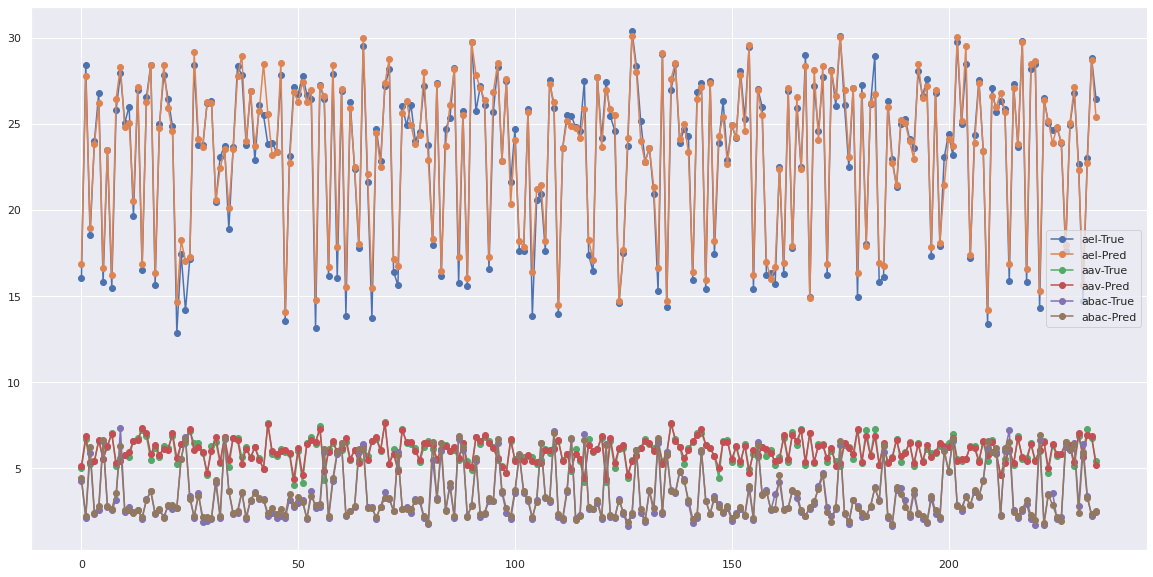

In [104]:
problem.plot_graphs()